In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import time
from scipy import integrate
import scipy
import scipy.stats as stats
from iminuit import Minuit
from tabulate import tabulate
import matplotlib.patches as patches

In [2]:
import pandas as pd

In [3]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14

### The decay $X \rightarrow D$ has the following probability density function: 

### $$\begin{equation} P(t; V, τ, ∆ms) ∝ (1 + V\sin(∆mt)) × \exp(−t/τ ) \end{equation}$$

- **t** is the observable quantity - the decay time of each decay;
- **τ** is a lifetime parameter;
- **V** is a parameter which measures matter/anti-matter asymmetry and has the value zero if the universe is symmetric;
- **∆m** is a mass difference parameter which leads to sinusoidal oscillations superimposed on the exponential decay.


The nominal values of the parameters are:

- $τ = 1.5$
- $V = 0.1$
- $∆m = 20.0$


## Part 1: Estimating statistical precision [4 marks]

$\textit{Use Monte Carlo simulations to determine the expected statistical precision with which one could measure each of the} \newline \textit{parameters with (i) 10,000 events and (ii) 100,000 events}$

In [4]:
#nominal value of X lifetime
tau = 1.5
#nominal value of matter/antimatter symmetry 
V = 0.1
#nominal value of mass shift
del_m = 20

In [5]:
#generating some times between 0 and 10 to plot
t = np.linspace(0,10,100000)

In [6]:
def pdf(t):
    """ generate the PDF of lifetime distributions """
    return (1 + V*np.sin(del_m*t)) * np.exp(-t/tau)

In [7]:
def neg_pdf(t):
    """ generate the negative PDF of lifetime distributions """
    return -(1 + V*np.sin(del_m*t)) * np.exp(-t/tau)

In [8]:
#guess of where maximum is for minimizer
max_idx = np.argmax(pdf(t))
#Need to maximize the function to find fmax, but scipy.optimize can only accept a minimization problem so I minimize neg pdf
minimizer = scipy.optimize.minimize(neg_pdf,x0=t[max_idx])
#flip f back to positive value
fmax = -1*minimizer.fun

In [9]:
#print maxima
fmax

1.0503389827704852

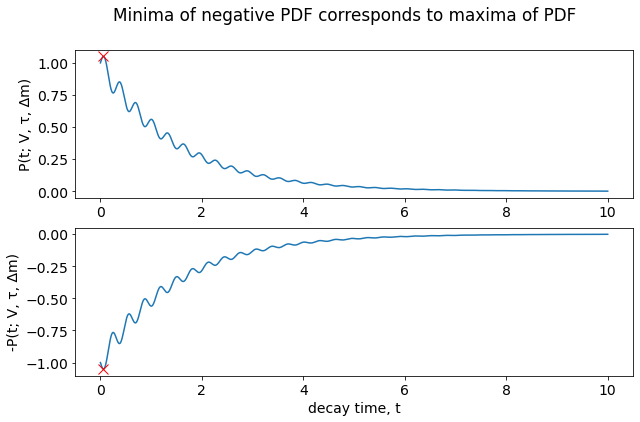

In [10]:
#a plot showing the positive and negative PDFs - and that the maxima of the normal PDF corresponds to the minima of its 
#negative, hence we can use a minimizer to find it exactly
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Minima of negative PDF corresponds to maxima of PDF')
ax1.plot(t, pdf(t))
ax1.plot(t[max_idx],pdf(t[max_idx]),'rx',markersize=10)
ax2.plot(t, -pdf(t))
ax2.plot(t[max_idx],-pdf(t[max_idx]),'rx',markersize=10)
plt.xlabel('decay time, t')
plt.ylabel('-P(t; V, τ, ∆m)')
ax1.set_ylabel('P(t; V, τ, ∆m)')
plt.show()

This plot shows the pdfs of the decaying particle X: the top graph shows the actual pdf, an exponential decay fitted overlayed with a sinusoidal oscillation, the bottom shows the negative pdf, this is to show that the minimum of the negative corresponds to the maximum of the positive pdf. I use a minimizer to find the minimum of the negative pdf and hence I find a maximum value (1.05) that is used to get values in the box algorithm below.

In [11]:
def box():
    """ rejection sampling via box method which draws random numbers from the PDF given above """
    
    while True:
        tmin = 0
        tmax = 10
        
        #Find a number fmax which is at least greater than the maximum value of f(t) in this range.
        fmax = 1.050339
        
        #Generate a random number t1 in the range 0-1
        t1 = np.random.uniform(0,1)
        
        #Convert it to a random number in the range [a,b] by the operation t1 = a + (b-a)*t1
        t1 = tmin + (tmax-tmin)*t1
        
        #Calculate the value, y1, of the function at t1, in other words y1= pdf(t1)
        y1 = pdf(t1)
        
        #Now generate another random number y2 in the range 0-1
        y2 = np.random.uniform(0,1)
        
        #Convert this to a random number in the rang [0,fmax] ] by the operation y2 = fmax*y2
        y2 = fmax*y2
        
        #If ( y2 < y1 ), return value of t1 to user, if false continue looping through until true
        if (y2<y1):
            filtered_t = t1
            return filtered_t

In [12]:
def decays(n_events):
    """ a function which takes in number of events and returns a list of decay times from the box function"""
    i = 0
    decay_times = []
    while i<n_events:
        decay_times.append(box())
        i+=1
    return decay_times   

In [13]:
#creating 100,000 decay times
decay_times = decays(100000)

In [14]:
def func(t, tau, V, del_m):
    
    """The normalized probability distribution function for optimizing which takes arguments of tau, V and del_m"""
    
    #t limits
    tmin = 0
    tmax = 10
    
    #normalization    
    norm = -(tau*np.exp(-10/tau)*(V*np.sin(10*del_m)+tau*V*del_m*np.cos(10*del_m)+(tau**2-tau**2*np.exp(10/tau))
                                  *del_m**2-tau*np.exp(10/tau)*V*del_m-np.exp(10/tau)+1))/(tau**2*del_m**2+1)
    
    return (1 + V*np.sin(del_m*t)) * np.exp(-t/tau) / norm

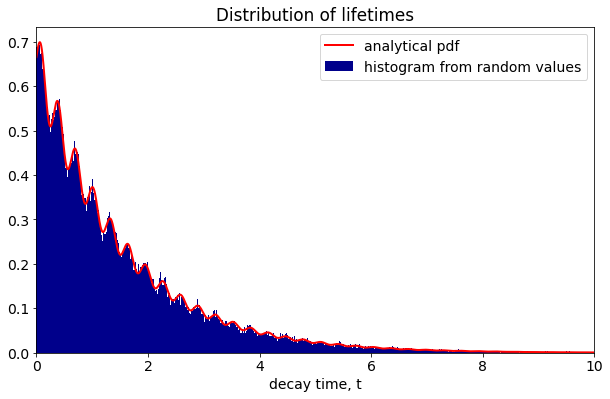

In [15]:
# Plot the histogram of random decay times 
plt.hist(decay_times, bins=500, density=True, color='darkblue', label = r'histogram from random values')

# Plot the analytical PDF.
# here we see it has exponential shape superimposed with sinusoidal oscillations
p = func(t, tau, V, del_m)
plt.plot(t, p, 'r', linewidth=2, label = r'analytical pdf')

plt.title(r'Distribution of lifetimes')
plt.xlim(0,10)
plt.legend()
plt.xlabel(r'decay time, t')

plt.show()

In [16]:
def get_NLL(tau, V, del_m): 
    
    """A function which generates the negative log likelihood of the function"""
    
    #define data as a global variable as we use this many times
    global DATA
    
    #generate the mean, mu using the PDF and guesses for the parameters
    mu = func(DATA, tau, V, del_m)
    
    #make sure that if mean is less than 10-4, return 10-4, so that there are no negative errors
    mu[mu<1e-4] = 1e-4
    
    #generate the log using the calculated mean
    LL = np.log(mu)
    
    #negative log likely hood is the negative of the sum over all log pmfs
    NLL = -np.sum(LL)
    
    return NLL

In order to properly determine the statistical error, the minimization by minuit should be run more than once. This is because of the inherent error due to randomly generating the data. I generate a function that generates the data 100 times, gets errors from minuit and returns a list of statistical errors for each parameter. I then take the mean of the list of 100 statistical errors to get an average, a more accurate statistical error. I produce these for both 10,000 events and 100,000 events.

In [17]:
def task1(n):
    i = 0
    #define empty lists of errors and values
    t_stat=[]
    v_stat=[]
    m_stat=[]
    t=[]
    v=[]
    delm=[]
    #generate 100 items in the list
    while i<100:
        global DATA
        DATA = np.asarray(decays(n))
        get_NLL.errordef = 0.5 
        m = Minuit(get_NLL, tau = 1.5, V = 0.1, del_m = 20)
        m.migrad()
        #append errors and values to lists
        t_stat.append(m.errors[0])
        v_stat.append(m.errors[1])
        m_stat.append(m.errors[2])
        t.append(m.values[0])
        v.append(m.values[1])
        delm.append(m.values[2])
        i+=1
    return t_stat, v_stat, m_stat, t, v, delm

In [18]:
#generating list of statistical errors for 10,000 events (the 4 on the variable name represents the number of zeros)
t_stat4, v_stat4, m_stat4, t_vals4, v_vals4, m_vals4 = task1(10000)

In [19]:
#getting statistical errors and values as mean of the corresponding list
E_t1 = np.mean(t_stat4)
E_V1 = np.mean(v_stat4)
E_m1 = np.mean(m_stat4) 
t1 = np.mean(t_vals4)
v1 = np.mean(v_vals4)
m1 = np.mean(m_vals4)

In [20]:
#generating list of statistical errors for 100,000 events
t_stat5, v_stat5, m_stat5, t_vals5, v_vals5, m_vals5  = task1(100000)

In [21]:
#getting statistical error as mean of list
E_t2 = np.mean(t_stat5)
E_V2 = np.mean(v_stat5)
E_m2 = np.mean(m_stat5)
t2 = np.mean(t_vals5)
v2 = np.mean(v_vals5)
m2 = np.mean(m_vals5)

In [22]:
print('statistical errors on tau, V and delta m with 10,000 simulated events:',E_t1, E_V1, E_m1)
print('statistical errors on tau, V and delta m with 100,000 simulated events:', E_t2, E_V2, E_m2)

statistical errors on tau, V and delta m with 10,000 simulated events: 0.015459241647058445 0.014174394615013125 0.06818187109912442
statistical errors on tau, V and delta m with 100,000 simulated events: 0.004889567777435383 0.004483571183407704 0.021724623030366333


#### 10,000 events:
$$E_{\text{tau}} = 0.015$$
$$E_V = 0.014$$
$$\Delta_m = 0.068$$

#### 100,000 events:
$$E_{\text{tau}} = 0.005$$
$$E_V = 0.004$$
$$\Delta_m = 0.021$$

Using a negative log likelihood function and passing it and the pdf to minuit, I generate the statistical errors. As expected the statistical errors are smaller for 100,000 events than that of 10,000 events as there are ten times as many events generated, and so less randomness in the data and so the better the fit. Statistical errors are roughly three times smaller as $\sqrt{10} \approx 3$. We can see that the 100,000 event provides a better fit when looking at the histograms of the data overlayed with the analytical pdf below:

We can also see that in both cases, delta m has a much larger statistical error, being the largest number and inside the sin argument.

In [23]:
DATA_E4 = np.asarray(decays(10000))

In [24]:
DATA_E5 = np.asarray(decays(100000))

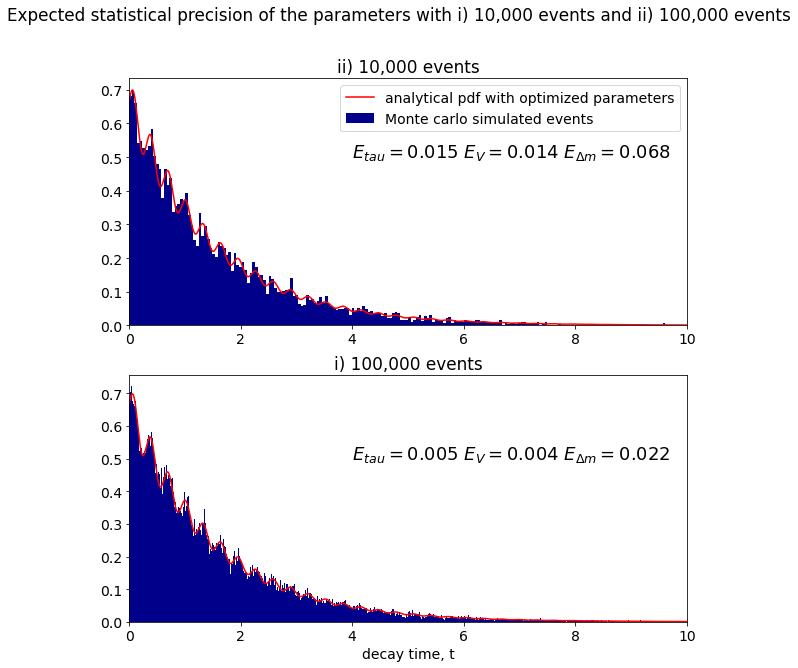

In [25]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
ax1.set_xlim(0,10)
ax2.set_xlim(0,10)
fig.suptitle('Expected statistical precision of the parameters with i) 10,000 events and ii) 100,000 events')

ax1.title.set_text('ii) 10,000 events')
ax1.annotate(xy=(4.,0.5),text=r'$E_{{tau}} = %1.3f$'%E_t1 + r' $E_V = %1.3f$'%E_V1 +r' $E_{\Delta m} = %1.3f$'%E_m1,fontsize=18)
ax1.plot(t,func(t, t1, v1, m1), color='r',label='analytical pdf with optimized parameters')
ax1.hist(DATA_E4, density=True, bins=200, color='darkblue', label='Monte carlo simulated events')

ax2.title.set_text('i) 100,000 events')
ax2.plot(t,func(t, t2, v2, m2),color='r', label='analytical pdf with optimized parameters')
ax2.hist(DATA_E5, density=True, bins=1000, color='darkblue',label='Monte carlo simulated events')
ax2.annotate(xy=(4.,0.5),text=r'$E_{{tau}} = %1.3f$'%E_t2 + r' $E_V = %1.3f$'%E_V2 +r' $E_{\Delta m} = %1.3f$'%E_m2,fontsize=18)

ax2.set_xlabel('decay time, t')
ax1.legend()
plt.show()

As statistical error decreases when going from 10,000 events to 100,000, I also generate 1,000,000 events to see how much accuracy changes by. Increasing the number of data points from 100,000 to 1000,000 doesn't improve accuracy as much, suggesting that it converges on a optimal value of time points, as expected. As the more data there is the more accurate the fit can be as it will eventually become smooth and fit to the pdf.

In [26]:
#set data to be the simulated toy experiments of 1 million events
DATA = np.asarray(decays(1000000))
#give guesses for lifetime, symmetry ratio and mass difference (ie the nominal values)
m_E6 = Minuit(get_NLL, tau = 1.5, V = 0.1, del_m = 20)

In [27]:
m_E6.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.389e+06                  │              Nfcn = 49               │
│ EDM = 4.57e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau   │  1.4991   │  0.0015   │            │            │         │         │       │
│ 1 │ V     │  0.1004   │  0.0014   │            │            │         │         │       │
│ 2 │ del_m │  20.003   │   0.007   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │       tau         V     del_m │
├───────┼───────────────────────────────┤
│   tau │  2.39e-06  1.05e-07 -8.53e-11 │
│     V │  1.05e-07  2.01e-06 -6.09e-08 │
│ del_m │ -8.53e-11 -6.09e-08  4.55e-05 │
└───────┴───────────────────────────────┘

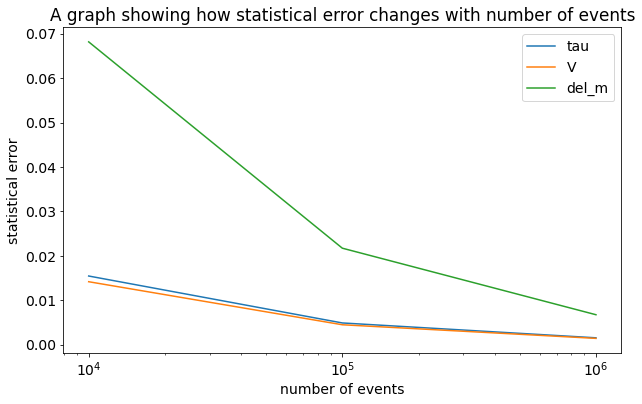

In [28]:
E1 = [E_t1, E_V1, E_m1]
E2 = [E_t2, E_V2, E_m2]
params = ['tau','V','del_m']
for i in range(3):

    plt.plot((10000,100000,1000000),(E1[i],E2[i],m_E6.errors[i]),label=params[i])
plt.xscale('log')
plt.xlabel('number of events')
plt.ylabel('statistical error')
plt.legend()
plt.title('A graph showing how statistical error changes with number of events')
plt.show()

Whilst 1 million events has only been run once, I can get an estimate for the trend in the graph, which plots statistical error against number of events. Tau and V are very similar in error and converge to the same point after 1 million runs. We can see that overall there is a decrease in error from 10^4 to 10^5, and a less steep decrease from 10^5 to 10^6 events, for all three parameters. $\Delta m$ has the largest error and is set apart from the other two parameters, this is most likely due to $\Delta m$ being the largest value. I predict even more runs would reduce statistical error further until an optimal number is reached as the graph will converge to some point.

Despite giving minuit the optimal values as guesses, the fitting does not return these values, this is because generating data from the nominal values doesn't mean the distribution of the data is perfect, this is because the mean of the data generated will be normally distributed around the mean of the distribution but not ever equal, hence we always have some statistical error.

---
A further investigation into statistical error: another factor that may influence the generated parameters is the range of decay values. The timescale of the decay is cut at 10 to speed up computing time, however in reality there are most likely be decays beyond this which are not accounted for. In order to check for this, I will repeat the simulation for tmax = 20, to see if there is any difference to the error or values.

In [29]:
#repeating box method and fitting for tmax = 20

In [30]:
def box20():
    """ rejection sampling via box method which draws random numbers from the PDF given above for t = 20"""
    
    while True:
        tmin = 0
        #changed tmax from 10 to 20
        tmax = 20
        
        fmax = 1.050339
        t1 = np.random.uniform(0,1)
        t1 = tmin + (tmax-tmin)*t1
        y1 = pdf(t1)
        y2 = np.random.uniform(0,1)
        y2 = fmax*y2
        if (y2<y1):
            filtered_t = t1
            return filtered_t

In [31]:
def decays20(n_events):
    """ a function which takes in number of events and returns a list of decay times from the box function for tmax = 20"""
    i = 0
    decay_times = []
    while i<n_events:
        decay_times.append(box20())
        i+=1
    return decay_times   

In [32]:
#set data to be the simulated toy experiments of 10,000 events for the new tmax
DATA = np.asarray(decays20(10000))
#give guesses for lifetime, symmetry ratio and mass difference (ie the nominal values)
m_E4_20 = Minuit(get_NLL, tau = 1.5, V = 0.1, del_m = 20)

In [33]:
#minimize the function with 10,000 events and tmax = 20
m_E4_20.migrad();

In [34]:
#set data to be the simulated toy experiments of 100,000 events for the new tmax
DATA = np.asarray(decays20(100000))
#give guesses for lifetime, symmetry ratio and mass difference (ie the nominal values)
m_E5_20 = Minuit(get_NLL, tau = 1.5, V = 0.1, del_m = 20)

In [35]:
#minimize the function with 100,000 events and tmax = 20
m_E5_20.migrad();

In [36]:
print('statistical errors for tmax = 20 on tau, V and delta m with 10,000 simulated events:',m_E4_20.errors[0,1,2])
print('statistical errors for tmax = 10 on tau, V and delta m with 10,000 simulated events:',[E_t1,E_V1,E_m1])

statistical errors for tmax = 20 on tau, V and delta m with 10,000 simulated events: [0.015273510389237467, 0.014164137667854177, 0.06360407872290905]
statistical errors for tmax = 10 on tau, V and delta m with 10,000 simulated events: [0.015459241647058445, 0.014174394615013125, 0.06818187109912442]


In [37]:
print('statistical errors for tmax = 20 on tau, V and delta m with 100,000 simulated events:',m_E5_20.errors[0,1,2])
print('statistical errors for tmax = 10 on tau, V and delta m with 100,000 simulated events:',[E_t2,E_V2,E_m2])

statistical errors for tmax = 20 on tau, V and delta m with 100,000 simulated events: [0.004911543911485654, 0.004481290401058497, 0.02133375313945139]
statistical errors for tmax = 10 on tau, V and delta m with 100,000 simulated events: [0.004889567777435383, 0.004483571183407704, 0.021724623030366333]


In [38]:
print('values for tmax = 20 on tau, V and delta m with 10,000 simulated events:',m_E4_20.values[0,1,2])
print('values for tmax = 10 on tau, V and delta m with 10,000 simulated events:',[t1,v1,m1])

values for tmax = 20 on tau, V and delta m with 10,000 simulated events: [1.483709785542118, 0.09247208229642152, 19.99893910988365]
values for tmax = 10 on tau, V and delta m with 10,000 simulated events: [1.4997596735764334, 0.10142214744678123, 19.994675338236693]


In [39]:
print('values for tmax = 20 on tau, V and delta m with 100,000 simulated events:',m_E5_20.values[0,1,2])
print('values for tmax = 10 on tau, V and delta m with 100,000 simulated events:',[t2,v2,m2])

values for tmax = 20 on tau, V and delta m with 100,000 simulated events: [1.505871855461118, 0.09564114562868897, 19.996280699806526]
values for tmax = 10 on tau, V and delta m with 100,000 simulated events: [1.5000355616283825, 0.09938665576920881, 20.00019174808187]


I can conclude that to three significant figues, the statistical errors are unchanged when changing tmax from 10 to 20, for both the 10,000 and 100,000 events. The values are also the same to 2 significant figures. Therefore through the rest of the analysis I will use tmax = 10 to reduce computing time, as this cutting of long decay times does not effect the statistical error. Furthermore, the parameters are actually closer to the nominal values for tmax = 10.

## Part 2: Estimating possible bias due to time resolution [3 marks]

In reality the decay time is measured with a resolution (random error) with a standard deviation of of σ = f$\tau$ where f is some fraction. What this means is that if the true decay time is $t_{\text{true}}$, then it is actually measured as t where t is distributed around $t_{\text{true}}$ with a Gaussian probability distribution with standard deviation σ. Determine the bias which will be introduced to the measurement of each of the parameters, when the data is subject to the resolution effect, but this is not included into the PDF used for fitting (measuring) the parameters. You should do this for the case of a 10,000 event data sample. Use both f = 0.01 and f = 0.03 and in each case compare the bias (if any) to the expected statistical precision.


$\textit{Hint: this means producing monte-carlo data where you include the effect of resolution on the decay times} \newline
\textit{you create randomly, but then fitting to it without allowing for this in the PDF}$


In [40]:
def toy_bias(f):
    
    """ A box function which generates both true time values and a distorted time value due to the detector resolution """
    
    #the standard deviation (i.e. shift in the data) due to the imperfect time resolution of the detector
    std = f*tau
    
    while True:
        #minimum and maximum decay times
        tmin = 0
        tmax = 10
        
        #Find a number fmax which is at least greater than the maximum value of f(t) in this range.
        fmax = 1.05033898
        
        #Generate a random number t1 in the range 0-1
        t1 = np.random.uniform(0,1)
        
        #Convert it to a random number in the range [a,b] by the operation t1 = a + (b-a)*t1
        t1 = tmin + (tmax-tmin)*t1
        
        #Calculate the value, y1, of the function at t1 (un-normalized to save computation time) y1= pdf(t1)
        y1 = pdf(t1)
        
        #Now generate another random number y2 in the range 0-1
        y2 = np.random.uniform(0,1)
        
        #Convert this to a random number in the range [0,fmax] by the operation y2 = fmax*y2
        y2 = fmax*y2
        
        #If ( y2 < y1 ), return value of t1 to user, if false continue looping through until true
        if (y2<y1):
            true_t = t1
            
            #true decay time true_t is measured as measured_t
            #where measured_t is distributed around true_t with a Gaussian pdf with standard deviation σ:
            measured_t = np.random.normal(loc = true_t, scale = std)
            
            #return true time and measured time so that the difference of the two can be compared to measure bias
            return measured_t, true_t

In [41]:
def decays_bias(f):
    
    """ A function which generates decay times subject to a bias due to imperfect time resolution"""
    i = 0
    measured_t = []
    true_t = []
    
    #generate 10,000 true events and 10,000 measured events for a given fraction, f
    while i<10000:
        measured_t.append(toy_bias(f)[0])
        true_t.append(toy_bias(f)[1])
        i+=1
    return measured_t, true_t  

In [42]:
######################################################################
#A copy of the negative log likelihood function again to refer back to
######################################################################

def get_NLL(tau, V, del_m): 
    
    """A function which generates the negative log likelihood of the function"""
    global DATA
    
    #generate the mean, mu using the standard PDF 'func' as we fit the data without allowing for time resolution in the PDF

    mu = func(DATA, tau, V, del_m)
    
    #make sure that if mean is less than 10-4, return 10-4, so that there are no negative errors
    mu[mu<1e-4] = 1e-4
    
    #generate the log using the calculated mean
    LL = np.log(mu)
    
    #negative log likely hood is the negative of the sum over all log pmfs
    NLL = -np.sum(LL)
    
    return NLL

In [43]:
#set function to the miniut likelihood value, 0.5, then NLL function will be treated as a minimiser
get_NLL.errordef = Minuit.LIKELIHOOD

### f = 0.01

In [44]:
#generate list of measured times and true times for a fraction of 0.01
measured_t01, true_t01 = decays_bias(0.01)

In [45]:
#set data to be the biased decay times of simulated toy experiments of 10,000 events for f=0.01
DATA = np.asarray(measured_t01)

#give guesses for lifetime, symmetry ratio and mass difference
m_task2_01 = Minuit(get_NLL, tau = 1.5, V = 0.1, del_m = 20)

In [46]:
#minimize fit for f = 0.01
m_task2_01.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.406e+04                  │              Nfcn = 43               │
│ EDM = 7.18e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau   │   1.524   │   0.016   │            │            │         │         │       │
│ 1 │ V     │   0.083   │   0.014   │            │            │         │         │       │
│ 2 │ del_m │   19.98   │   0.09    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │       tau         V     del_m │
├───────┼───────────────────────────────┤
│   tau │  0.000248  1.04e-05   7.1e-07 │
│     V │  1.04e-05  0.000198 -5.31e-06 │
│ del_m │   7.1e-07 -5.31e-06   0.00832 │
└───────┴───────────────────────────────┘

### f = 0.03

In [47]:
#generate list of measured times and true times for a fraction of 0.03
measured_t03, true_t03 = decays_bias(0.03)

In [48]:
#set data to be the simulated toy experiments of 10,000 events for f = 0.03
DATA = np.asarray(measured_t03)

#give guesses for lifetime, symmetry ratio and mass difference
m_task2_03 = Minuit(get_NLL, tau = 1.5, V = 0.1, del_m = 20)

In [49]:
#minimize fit for f=0.03
m_task2_03.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.386e+04                  │              Nfcn = 51               │
│ EDM = 2.63e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau   │   1.488   │   0.015   │            │            │         │         │       │
│ 1 │ V     │   0.042   │   0.014   │            │            │         │         │       │
│ 2 │ del_m │   20.12   │   0.10    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │       tau         V     del_m │
├───────┼───────────────────────────────┤
│   tau │  0.000235  1.05e-05 -2.16e-06 │
│     V │  1.05e-05  0.000201 -1.67e-05 │
│ del_m │ -2.16e-06 -1.67e-05    0.0104 │
└───────┴───────────────────────────────┘

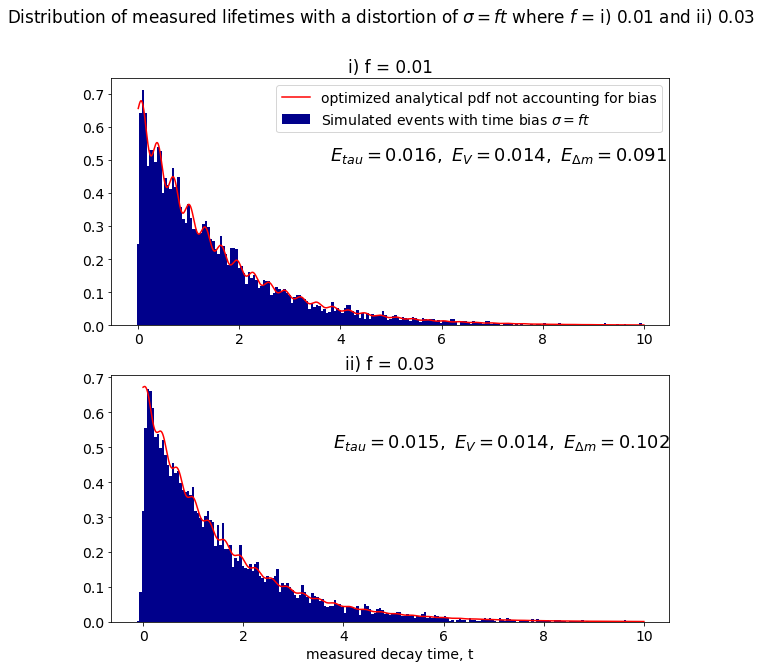

In [50]:
#create a plot that shows the measured decay times for a distortion of sigma=0.01t and sigma=0.03t and the corresponding
#minimized pdf

fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))

fig.suptitle('Distribution of measured lifetimes with a distortion of $\sigma = ft$ where $f$ = i) 0.01 and ii) 0.03')

ax1.title.set_text('i) f = 0.01')
ax1.hist(measured_t01, density=True, bins=200, color='darkblue',label='Simulated events with time bias $\sigma = ft$')
ax1.plot(t,func(t, m_task2_01.values[0], m_task2_01.values[1], m_task2_01.values[2]),color='r', label='optimized analytical pdf not accounting for bias')
ax1.annotate(xy=(3.8,0.5),text=r'$E_{{tau}} = %1.3f,$'%m_task2_01.errors[0] + r' $E_V = %1.3f,$'%m_task2_01.errors[1] +r' $E_{\Delta m} = %1.3f$'%m_task2_01.errors[2],fontsize=18)

ax2.title.set_text('ii) f = 0.03')
ax2.hist(measured_t03, density=True, bins=200, color='darkblue', label='Monte carlo simulated events')
ax2.plot(t,func(t, m_task2_03.values[0], m_task2_03.values[1], m_task2_03.values[2]), color='r',label = 'analytical pdf with optimized parameters')
ax2.annotate(xy=(3.8,0.5),text=r'$E_{{tau}} = %1.3f,$'%m_task2_03.errors[0] + r' $E_V = %1.3f,$'%m_task2_03.errors[1] +r' $E_{\Delta m} = %1.3f$'%m_task2_03.errors[2],fontsize=18)

ax2.set_xlabel('measured decay time, t')
ax1.legend()
plt.show()

The figure shows the generated monte carlo data that is **measured** by the detector for f = 0.01 and f = 0.03, the measured times for f=0.03 are going to have **more of a spread** (due to a larger standard deviation) and so the fit (which assumes the normal pdf and doesnt account for resolution) is going to be **worse**. As we can see from the figure, the fit is smeared, and the sinusoidal oscillations are not as apparent. Adding a shift of $\sigma =$ ft to the time data, generates a shift in t. We can see that the magnitude of the sinusoidal oscillations is compressed whereas the period appears to occur at the same time points, so it seems most likely that V will change but m not so much. The exponential seems to have the same curve and so tau may not be biased as V. The bias will be worse for f=0.03 and less so for f = 0.01.

The bias is the mean of the difference between the results generated by minuit when fitting to the distorted data, and when fitting to the true data. In order to test whether the time resolving power of the detector introduces a bias in the data, we run the simulation (which generates 10,000 events) 100 times. We can then visualise the bias by plotting the histogram of the shift between parameter values fitted to true times and distorted times. We then observe its shift from the value 0. If values are shifted from 0 it appears to have bias, however whether or not the bias is relevant depends on the precision of the bias, which is the standard error ( standard deviation of the histogram over the square root of the number of simulations $\sqrt{100} = 10$). 

In [51]:
def generate_biases(f):
    
    """ A function that generates 100 runs each consisting of 10,000 events. It generates 100 values for each parameter:
    the difference between the parameter values generated by minuit for a) the measured and b) the true data. The bias 
    is then taken to be the mean of these values """
    
    global DATA
    
    #initialization
    i = 0
    t_bias = []
    V_bias = []
    m_bias = []
    
    #generate 100 runs
    while i < 100:
        #generate a set of true times
        undistorted = decays_bias(f)[1]
        #generate a set of measured times
        distorted = decays_bias(f)[0]
        
        #minimize for true times, get parameter values
        DATA = np.asarray(undistorted)
        #set error of NLL to 0.5
        get_NLL.errordef = 0.5 
        #give guesses for lifetime, symmetry ratio and mass difference
        m1 = Minuit(get_NLL, tau = 1.5, V = 0.1, del_m = 20)
        #minimize the fit
        m1.migrad()
        
        #minimize for measured times, get parameter values
        DATA = np.asarray(distorted)
        m2 = Minuit(get_NLL, tau = 1.5, V = 0.1, del_m = 20)
        m2.migrad()
        
        #get biases by taking away minuits parameters for true times from minuits parameters for measured times
        t_bias.append(m1.values[0]-m2.values[0])
        V_bias.append(m1.values[1]-m2.values[1])
        m_bias.append(m1.values[2]-m2.values[2])
        i+=1
    return t_bias,V_bias,m_bias

In [52]:
#get biases for f=0.01
t_biases01,V_biases01,m_biases01 = generate_biases(0.01)

In [53]:
#fitting histogram to gaussian to obtain mean (bias) and standard deviation on parameters
mu_t,std_t = stats.norm.fit(t_biases01, loc=0, scale=1) 
mu_V,std_V = stats.norm.fit(V_biases01, loc=0, scale=1)
mu_m,std_m = stats.norm.fit(m_biases01, loc=0, scale=1) 
print('mean and std for the bias on lifetime for f=0.01 are  %1.5f'%mu_t, 'and  %1.5f'%std_t,'respectively')
print('mean and std for the bias on V for f=0.01 are %1.5f'%mu_V, 'and %1.5f'%std_V,'respectively')
print('mean and std for the bias on m for f=0.01 are %1.5f'%mu_m, 'and %1.5f'%std_m,'respectively')

mean and std for the bias on lifetime for f=0.01 are  0.00000 and  0.02309 respectively
mean and std for the bias on V for f=0.01 are 0.01330 and 0.01800 respectively
mean and std for the bias on m for f=0.01 are 0.00833 and 0.10840 respectively


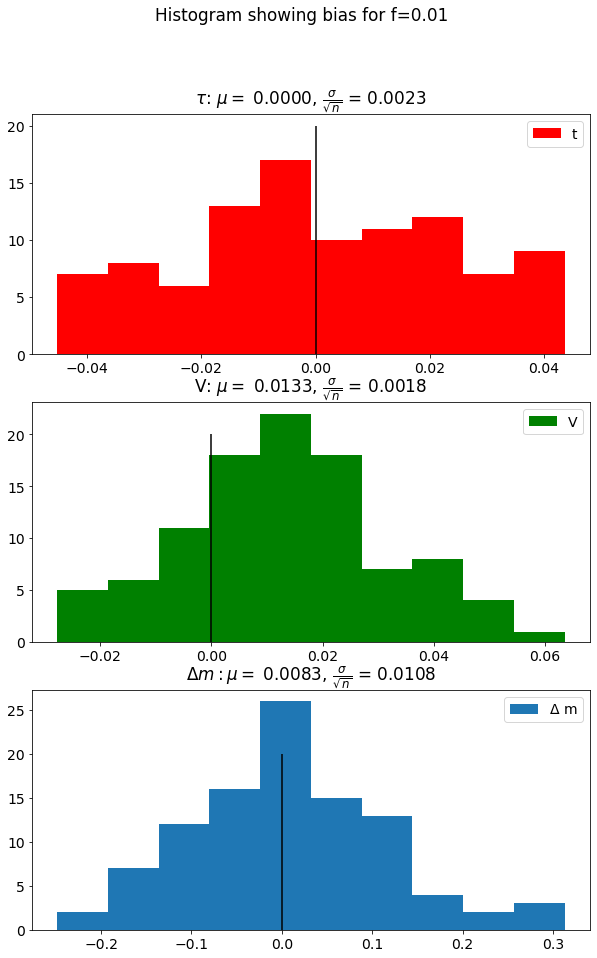

In [54]:
#get histograms for biases on all three parameters
fig, axs = plt.subplots(3,figsize=(10,15))
fig.suptitle('Histogram showing bias for f=0.01')
axs[0].hist(t_biases01,color='r',label='t')
axs[1].hist(V_biases01,color='g',label='V')
axs[2].hist(m_biases01,label='$\Delta$ m')

#plot at the 0 line to see shift 
axs[0].vlines(0,0,20,'k')
axs[1].vlines(0,0,20,'k')
axs[2].vlines(0,0,20,'k')

#label plots by their bias and the error on the bias
#standard error is calculated as standard deviation over root (no. samples) which in this case is root(100) = 10
axs[0].title.set_text(r'$\tau$: $\mu =$ %1.4f'%mu_t + ', ' + r'$\frac{\sigma}{\sqrt{n}}$ = %1.4f'%(std_t/10))
axs[1].title.set_text('V: $\mu =$ %1.4f'%mu_V + ', ' + r'$\frac{\sigma}{\sqrt{n}}$ = %1.4f'%(std_V/10))
axs[2].title.set_text('$\Delta m: \mu =$ %1.4f'%mu_m + ', ' + r'$\frac{\sigma}{\sqrt{n}}$ = %1.4f'%(std_m/10))

axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

#### Biases for f=0.01
Tau has no bias, it is centered on 0 to four significant figures and has a relatively small standard error so it can be said to be statistically relevant, so shifting the values of decay times does not effect the lifetime. This is to be expected as tau is inside the exponential and shifting the values of t by some standard deviation will not affect the decay constant, from the fits above we can see that the exponential still has the same shape regardless of this distortion due to time resolution, so it can be predicted that the exponential factor isn't affected. V appears to have bias as its mean is centred on 0.0133 and it has a standard error ~1/10 of this. From the graphs above we can also deduct this as V is the height of the sinusoidal part of the function, and as we can see the oscillations are compressed. The mass parameter has a bias of 0.0083 however has a standard error of 0.0108, that is larger than the mean, and so the bias cannot be claimed to be statistically relevant.

$V$ is the amplitude of the oscillations and $\Delta m$ is the period. By changing f, which smears the values, we can see the period stays the same however the amplitude is compressed. So it is expected that V would have the highest bias over tau and $\Delta m$. The bias on $\Delta m$ is similar to its standard error, so whether or not it is biased is undetermined. $\Delta m$ is inside the sin argument and is quite a big value of 20, so changing t values by 0.01 changes the sin argument by 0.2x. This means that as t values are shifted the sin values shift, however sin is periodic, so the bias on $\Delta m$ is hard to determine.

In [55]:
#compare the bias (if any) to the expected statistical precision

data_01 = {'Parameter': ['tau', 'V', 'm'],
        'Statistical error': [E_t1, E_V1, E_m1],
        'Bias': [abs(mu_t), abs(mu_V), abs(mu_m)],
        'Error on bias': [std_t/10, std_V/10, std_m/10]}

df_01 = pd.DataFrame(data_01)
df_01.style.set_table_attributes("style='display:inline'").set_caption('f = 0.01')

,Parameter,Statistical error,Bias,Error on bias
0,tau,0.015459,0.000004,0.002309
1,V,0.014174,0.013301,0.001800
2,m,0.068182,0.008332,0.010840


Comparing the bias to the statistical error, we can see that whilst tau has the highest statistical error and no bias, V has a statistical error 20 times larger than the bias so the error due to bias is small in comparison, despite V having the only (very small) bias  due to f=0.01. M has the largest statistical error and is the largest number, however whether it has bias or not due to the detector resolution is inconclusive. For f = 0.01, comparing statistical errors to bias we can see there is relatively small systematic errors due to bias. The bias on V, which is the largest bias here, is very small compared to the statistical error. So for f=0.01, there isn't much bias due to the detector.

Looking at the values given by minuit for the parameters for f = 0.01 gives values for tau V and m as 1.524, 0.083 and 19.98, where the nominal values are 1.5, 0.1 and 20.0. We can see that the largest percentage error is in V, whilst tau is incorrect too, it has a larger value and so a smaller percentage error.

In [56]:
t_biases03,V_biases03,m_biases03 = generate_biases(0.03)

In [57]:
mu_t3,std_t3 = stats.norm.fit(t_biases03, loc=0, scale=1)
mu_V3,std_V3 = stats.norm.fit(V_biases03, loc=0, scale=1) 
mu_m3,std_m3 = stats.norm.fit(m_biases03, loc=0, scale=1) 

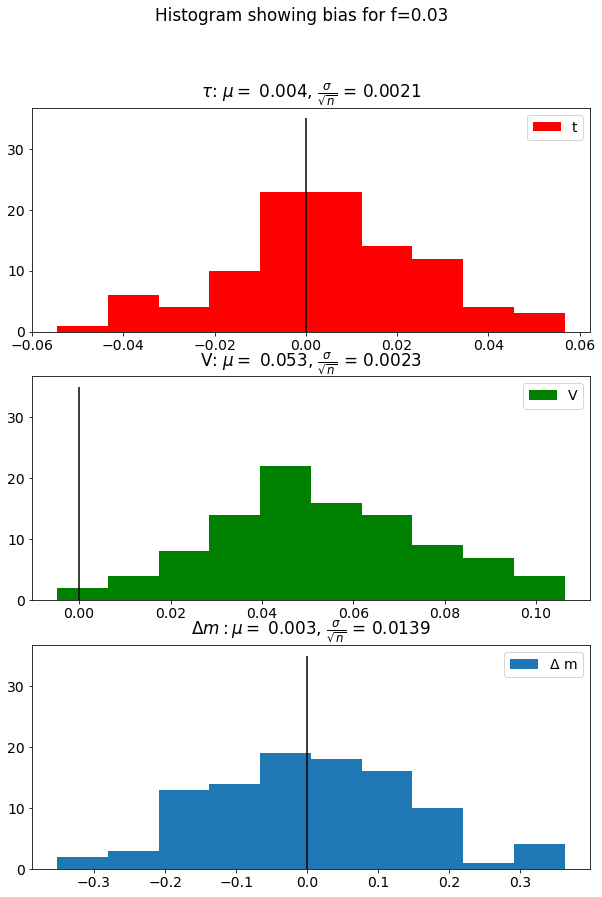

In [58]:
fig, axs = plt.subplots(3,figsize=(10,14))
fig.suptitle('Histogram showing bias for f=0.03')
axs[0].hist(t_biases03,color='r',label='t')
axs[1].hist(V_biases03,color='g',label='V')
axs[2].hist(m_biases03,label='$\Delta$ m')
axs[0].vlines(0,0,35,'k')
axs[0].title.set_text(r'$\tau$: $\mu =$ %1.3f'%mu_t3 + ', ' + r'$\frac{\sigma}{\sqrt{n}}$ = %1.4f'%(std_t3/10))

axs[1].vlines(0,0,35,'k')
axs[1].title.set_text('V: $\mu =$ %1.3f'%mu_V3 + ', ' + r'$\frac{\sigma}{\sqrt{n}}$ = %1.4f'%(std_V3/10))

axs[2].vlines(0,0,35,'k')
axs[2].title.set_text('$\Delta m: \mu =$ %1.3f'%mu_m3 + ', ' + r'$\frac{\sigma}{\sqrt{n}}$ = %1.4f'%(std_m3/10))

axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

#### Biases for f = 0.03

Since f is the amount the measured times are shifted by, I expect the bias for f=0.03 to be bigger. Here we can see that it is: tau goes from 0 to 0.004 (still essentially no bias), mass parameter from 0.0083 to 0.003 (still with a standard error great than the mean, and thus whether or not detector resolution introduced a bias to m values is inconclusive) and V, the most important parameter here as it appears to be the most biased, has a bias of 0.053, with a standard error small in comparison so it can be deemed statistically relevant. For f=0.01, bias on V was 0.0133 with a standard error 10% of this, here, V's bias is 4 times as large, with a standard error 23 times smaller than its bias. It can be concluded that for f=0.03 there is a definite bias in V. From looking at the pdf and the graph, V controlls the height of the oscillations. For f=0.03 data we can see that the oscillations are less prominant, which suggests that there will be in a bias in V. We can also look at the generated parameter for V given by minuit for f = 0.03: the value is 0.042, where the nominal value is 0.1, so we can see it is way off. This suggests a large error due to bias.

We can see that tau and m are much closer to their nominal values, 1.49 and 20.12 respectively, and can conclude that they are most likely unbiased in this case.

In [59]:
#compare the bias (if any) to the expected statistical precision

data_03 = {'Parameter': ['tau', 'V', 'm'],
        'Statistical error': [E_t1, E_V1, E_m1],
        'Bias': [abs(mu_t3), abs(mu_V3), abs(mu_m3)],
        'Error on bias': [std_t3/10, std_V3/10, std_m3/10]}

df_03 = pd.DataFrame(data_03)
df_03.style.set_table_attributes("style='display:inline'").set_caption('f = 0.03')

,Parameter,Statistical error,Bias,Error on bias
0,tau,0.015459,0.003924,0.002098
1,V,0.014174,0.053256,0.002263
2,m,0.068182,0.002931,0.013919


To further support this claim that there is bias in V due to distortion, we can see that the bias in V is much larger than its statistical error, and so this is a significant systematic error due to bias: for f = 0.03, **$V = 0.042 \pm 0.014 \pm 0.053$**

The bias on tau is four times smaller than its statistical error and the bias on m statistically irrelevant. If the error on the bias for m were smaller, the bias itself is still ~23 times smaller than the statistical error so we can conclude detector resolution only really induces a bias on V.

## Part 3: Estimating a systematic error due to time acceptance [3 marks]

The method of measuring decay-time (i.e. in some detector) is thought to exhibit a decay-time
acceptance given by a(t) = (1 + st) where s is only known with a precision of s = 0 ± 0.03
Determine a suitable systematic error to assign to the measurement of each of the parameters
due to this this limited knowledge of a(t) and in each case compare the this systematic error (if
any) to the expected statistical precision.
Hint: This is a stretch part of the project. You will need to understand all of the slides on acceptance in
the notes to do this. For this part you will have to generate data and fit it twice. This means you will have
to include the acceptance function in the PDF and in its normalisation.


In [60]:
def mod_func(t, s, tau, V, del_m):
    """ Generates a pdf including time acceptance (not normalized)"""
    
    #define pdf as lambda function
    f1 = lambda x1: (1 + V*np.sin(del_m*x1)) * np.exp(-x1/tau) * (1+s*x1)
    
    return f1(t)

In [61]:
def mod_func_norm(t, s, tau, V, del_m):
    
    """ Generates a normalized pdf including time acceptance """
    
    #define pdf as lambda function
    f1 = lambda x1: (1 + V*np.sin(del_m*x1)) * np.exp(-x1/tau) * (1+s*x1)
    
    #get normalization constant by integrating between the x
    norm = integrate.quad(f1, 0, 10)
     
    return f1(t) / norm[0]

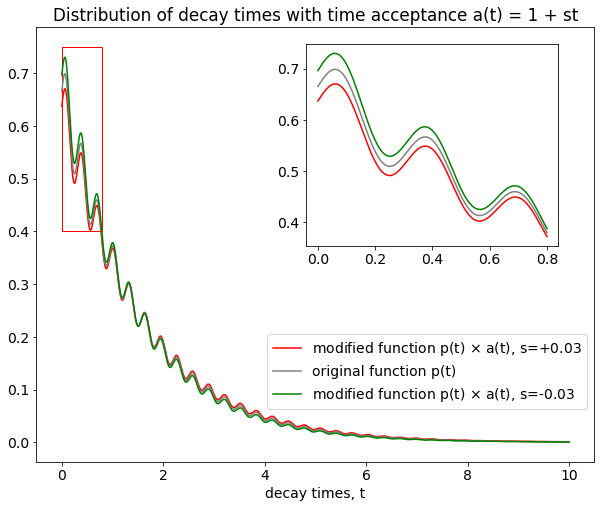

In [62]:
#plotting the decay times with the time acceptance added, for s = -0.03, 0, +0.03
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(t,mod_func_norm(t, 0.03, tau, V, del_m),label=r'modified function p(t) $\times$ a(t), s=+0.03',c='r')
ax.plot(t,func(t, tau, V, del_m),label='original function p(t)',c='gray')
ax.plot(t,mod_func_norm(t, -0.03, tau, V, del_m),label=r'modified function p(t) $\times$ a(t), s=-0.03',c='g')
ax.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.31))
ax.set_xlabel('decay times, t')
ax.set_title('Distribution of decay times with time acceptance a(t) = 1 + st')

# location for the zoomed portion 
sub_axes = plt.axes([.5, .5, .35, .35]) 

# Create a Rectangle patch
rect = patches.Rectangle((0, 0.4), 0.8, 0.35, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# plot the zoomed portion
sub_axes.plot(t[0:8000], mod_func_norm(t[0:8000],0.03, tau, V, del_m),c='r')
sub_axes.plot(t[0:8000], func(t[0:8000], tau, V, del_m),c='gray') 
sub_axes.plot(t[0:8000], mod_func_norm(t[0:8000],-0.03, tau, V, del_m),c='g') 
plt.show()

The figure above shows the normalized pdfs for s = 0, 0.03 and -0.03. We can see that for t close to 0, the time acceptance affects the function the most, stretching it above the norm for s=-0.03 and below for s=+0.03 (as it's normalised), toward longer decay times the modified and the original function tend toward eachother and look the same. This time acceptance is accounting for the imperfect detector being poorer at detecting decays at times close to 0. The systematic error will be due to the fact that we do not know what model to fit to the data, whether it's 0, $\pm$0.03 or inbetween.

We now perform the Monte Carlo study to generate random events for s = 0, and then fit to the data according to a modified function pdf(t) * a(t) where you a(t) = 1 + st where s is unknown.

To speed up the toy simulation we do not normalize for the box method so we use the unnormalized modified function, as fmax does that for us - we change fmax to be a bit larger as the function can be multiplied by a factor of 1.03.

In [63]:
def toy_acceptance(s):
    
    """ A function that generates decay times according to the modified function which includes time acceptance, a = 1 + st"""
        
    while True:
        #time limits
        tmin = 0
        tmax = 10
        
        #Find a number fmax which is at least greater than the maximum value of f(x) in this range.
        fmax = 1.1 #1.05033898
        
        #Generate a random number x1 in the range 0-1
        t1 = np.random.uniform(0,1)
        
        #Convert it to a random number in the range [a,b] by the operation x1 = a + (b-a)*x1
        t1 = tmin + (tmax-tmin)*t1
        
        #HERE WE USE MODERATED FUNC WHERE IT ACCOUNTS FOR TIME ACCEPTANCE -  
        #include the acceptance function in the PDF and in its normalisation.
        y1 = mod_func(t1, s, tau, V, del_m)
        
        #Now generate another random number y2 in the range 0-1
        y2 = np.random.uniform(0,1)
        
        #Convert this to a random number in the rang [0,fmax] ] by the operation y2 = fmax*y2
        y2 = fmax*y2
        
        #If ( y2 < y1 ), return value of x1 to user, if false continue looping through until true
        if (y2<y1):
            
            true_t = t1
            
            return true_t

In [64]:
def decays_acceptance(s):
    i = 0
    decay_times = []
    
    #generate 10,000 events with the time acceptance 
    while i<10000:
        decay_times.append(toy_acceptance(s))
        i+=1
        
    return decay_times  

In [65]:
def NLL_acceptance(s, tau, V, del_m): 
    
    """A function which generates the negative log likelihood of the modified function which includes time acceptance"""
    
    #generate the mean, mu using the standard PDF 'func' as we fit the data including time acceptance in the PDF
    global DATA
    mu = mod_func_norm(DATA, s, tau, V, del_m)
    
    #make sure that if mean is less than 10-4, return 10-4, so that there are no negative errors
    mu[mu<1e-4] = 1e-4
    
    #generate the log using the calculated mean
    LL = np.log(mu)
    
    #negative log likely hood is the negative of the sum over all log pmfs
    NLL = -np.sum(LL)
    
    return NLL

#### Method 1
- Change s to s + 0.03
- Re-run the fit and measure the shift it induces on the best fit physics parameters
- Change s to s - 0.03
- Re-run the fit and measure the shift, then take the average

In [66]:
task3_t = decays_acceptance(0)

In [67]:
#set data to be the simulated toy experiments of 10,000 events
global DATA
#set data to be the data from task3
DATA = np.asarray(task3_t)

#set error of NLL to 0.5
NLL_acceptance.errordef = 0.5 

#give guesses for lifetime, symmetry ratio and mass difference using the NLL acceptance function
acceptance_0 = Minuit(NLL_acceptance, s = 0, tau = 1.5, V = 0.1, del_m = 20)
#make sure s is fixed so minimizer doesn't adjust its value
acceptance_0.fixed['s'] = True

In [68]:
#minimize 
acceptance_0.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.375e+04                  │              Nfcn = 43               │
│ EDM = 3.77e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 1 │ tau   │   1.476   │   0.015   │            │            │         │         │       │
│ 2 │ V     │   0.088   │   0.014   │            │            │         │         │       │
│ 3 │ del_m │   19.89   │   0.06    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         s       tau         V     del_m │
├───────┼─────────────────────────────────────────┤
│     s │         0         0         0         0 │
│   tau │         0   0.00023  1.04e-05 -8.66e-08 │
│     V │         0  1.04e-05    0.0002 -3.67e-06 │
│ del_m │         0 -8.66e-08 -3.67e-06   0.00382 │
└───────┴─────────────────────────────────────────┘

In [69]:
#get minimizer values when s is positive 0.03
acceptance_pos = Minuit(NLL_acceptance, s = 0.03, tau = 1.5, V = 0.1, del_m = 20)
acceptance_pos.fixed['s'] = True

In [70]:
#minimize
acceptance_pos.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.375e+04                  │              Nfcn = 43               │
│ EDM = 4.93e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  30.0e-3  │  0.3e-3   │            │            │         │         │  yes  │
│ 1 │ tau   │   1.418   │   0.014   │            │            │         │         │       │
│ 2 │ V     │   0.088   │   0.014   │            │            │         │         │       │
│ 3 │ del_m │   19.89   │   0.06    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         s       tau         V     del_m │
├───────┼─────────────────────────────────────────┤
│     s │         0         0         0         0 │
│   tau │         0  0.000197   9.6e-06 -9.23e-08 │
│     V │         0   9.6e-06    0.0002 -3.63e-06 │
│ del_m │         0 -9.23e-08 -3.63e-06   0.00381 │
└───────┴─────────────────────────────────────────┘

In [71]:
#get minimizer values when s is negative 0.03
acceptance_neg = Minuit(NLL_acceptance, s = -0.03, tau = 1.5, V = 0.1, del_m = 20)
acceptance_neg.fixed['s'] = True
acceptance_neg.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.375e+04                  │              Nfcn = 55               │
│ EDM = 3.87e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │ -30.0e-3  │  -0.3e-3  │            │            │         │         │  yes  │
│ 1 │ tau   │   1.551   │   0.017   │            │            │         │         │       │
│ 2 │ V     │   0.088   │   0.014   │            │            │         │         │       │
│ 3 │ del_m │   19.89   │   0.06    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         s       tau         V     del_m │
├───────┼─────────────────────────────────────────┤
│     s │         0         0         0         0 │
│   tau │         0  0.000282  1.15e-05 -1.87e-07 │
│     V │         0  1.15e-05    0.0002 -4.77e-06 │
│ del_m │         0 -1.87e-07 -4.77e-06   0.00381 │
└───────┴─────────────────────────────────────────┘

In [72]:
#method 1 systematic errors:
#systematic error due to unknowns: difference in the parameter values when fitting for different values of s
#shift in values is the difference when fitting for s=0 and s= 0 +/- 0.03

In [73]:
pos_syst_err = []
neg_syst_err = []
for i in range(1,4):
    pos_syst_err.append(abs(acceptance_0.values[i]-acceptance_pos.values[i]))
    neg_syst_err.append(abs(acceptance_0.values[i]-acceptance_neg.values[i]))  

In [74]:
method1 = (np.asarray(pos_syst_err)+np.asarray(neg_syst_err))/2
method1

array([0.0665709 , 0.0001733 , 0.00022541])

Here we get the systematic errors from method 1: 0.067 for tau, 0.00017 for V and 0.00023 for m.

#### Method 2
- Pick random values of s from a Gaussian distribution centred on 0 with width 0.03
- Then re-run the fit with each s_random and measure the set of shifts it induces on the best fit physics parameters as usual. - Call these shift_i
- Plot this set of shift_i
- This should give a Gaussian distribution
- Take the standard deviation as the systematic error 

In [75]:
count = 0
shift_V = []
shift_t = []
shift_m = []
while count<100:
    
    #Pick random values of s_rand from a Gaussian distribution centred on 0 with width 0.03
    s_rand = np.random.normal(loc=0, scale=0.03)
    
    #Re-run the fit with each s_rand and measure the set of shifts it induces on the best fit physics parameters. 
    m_rand = Minuit(NLL_acceptance, s = s_rand, tau = 1.5, V = 0.1, del_m = 20)
    m_rand.fixed['s'] = True
    m_rand.migrad()
    
    #append to shift list
    #shift in values is the difference when fitting for s=0 and s=random no. centred on 0, std +/- 0.03
    shift_t.append(acceptance_0.values[1]-m_rand.values[1])
    shift_V.append(acceptance_0.values[2]-m_rand.values[2])
    shift_m.append(acceptance_0.values[3]-m_rand.values[3])

    count +=1

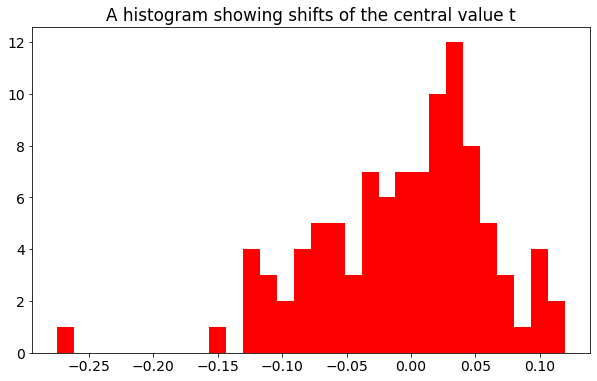

In [76]:
plt.hist(shift_t,bins=30,color='r');
plt.title('A histogram showing shifts of the central value t')
plt.show()

In [77]:
#fitting histogram to gaussian
mu,std = stats.norm.fit(shift_t, loc=0, scale=1) 
print('mean and standard deviation are', mu, 'and', std,'respectively')

mean and standard deviation are -0.006776667043375186 and 0.06611325996740669 respectively


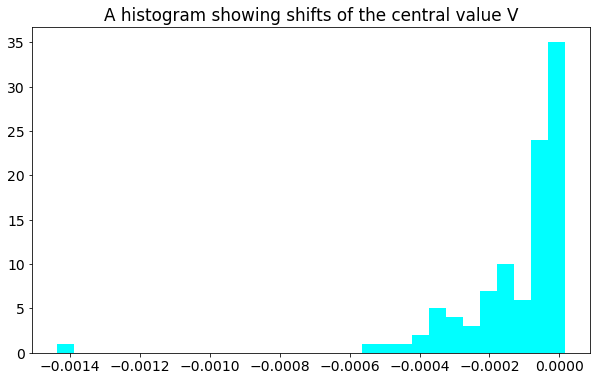

In [78]:
plt.hist(shift_V,bins=30,color='cyan');
plt.title('A histogram showing shifts of the central value V')
plt.show()

In [79]:
#fitting histogram to gaussian
mu,std = stats.norm.fit(shift_V, loc=0, scale=1) 
print('mean and standard deviation are', mu, 'and', std,'respectively')

mean and standard deviation are -0.00012927529120606866 and 0.0001809155324967347 respectively


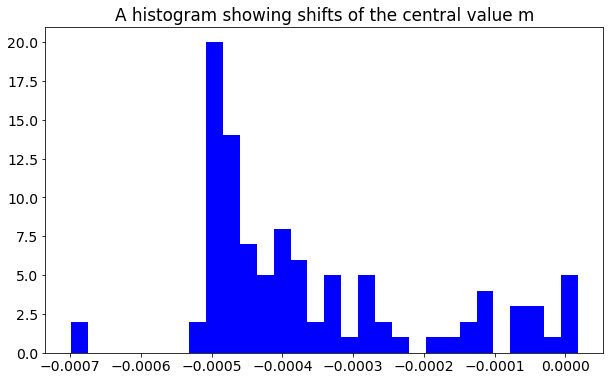

In [80]:
plt.hist(shift_m,bins=30,color='b');
plt.title('A histogram showing shifts of the central value m')
plt.show()

In [81]:
#fitting histogram to gaussian
mu,std = stats.norm.fit(shift_m, loc=0, scale=1) 
print('mean and standard deviation are', mu, 'and', std,'respectively')

mean and standard deviation are -0.0003582363634046715 and 0.000166219374842475 respectively


The systematic error is given by the standard deviation of the gaussian generated by method 2. Method 1 and method 2 agree: both V and m have very small systematic errors of ~0.0002 but tau has a large one ~0.7. Introducing the time accpetance function multiplies the whole function by 1.03 or 0.97. By not account for our lack of knowledge in $s = 0 \pm 0.03$ we introduce a systematic error in tau: for +0.03 tau is given by $\tau = 1.418 \pm 0.014 \pm 0.07$. The systematic error is 5 times larger than the statistical error. For -0.03, $\tau = 1.551 \pm 0.017 \pm 0.07$, the systematic error is ~4 times larger.



From the plot of the three pdfs above for s = 0, s = +0.03 and s = -0.03, we can see that the exponential is stretched and compressed. This is most likely to change the exponential decay constant and so not knowing the value of s introduces a systematic error on tau as it is inside the exponential.

---
### Summary:

For 10,000 events:

f=0.01

$\tau: E_{stat} = \pm 0.015,  E_{syst} \text{ (due to bias)} = \pm 0.000,  E_{syst} \text{ (due to time acceptance)} \pm 0.07$
$V : E_{stat} = \pm 0.014, E_{syst} \text{ (due to bias)} = \pm 0.0133,  E_{syst} \text{ (due to time acceptance)} \pm 0.0002$
$\Delta_m: E_{stat} = \pm 0.068, E_{syst} \text{ (due to bias)} \approx 0 \text{ (inconclusive)},  E_{syst} \text{ (due to time acceptance)} \pm 0.0002$

f=0.03

$\tau: E_{stat} = \pm 0.015,  E_{syst} \text{ (due to bias)} = \pm 0.004,  E_{syst} \text{ (due to time acceptance)} \pm 0.07$
$V : E_{stat} = \pm 0.014, E_{syst} \text{ (due to bias)} = \pm 0.053,  E_{syst} \text{ (due to time acceptance)} \pm 0.0002$
$\Delta_m: E_{stat} = \pm 0.068, E_{syst} \text{ (due to bias)} \approx 0 \text{ (inconclusive)},  E_{syst} \text{ (due to time acceptance)} \pm 0.0002$

V has the largest systematic error due to bias due to time resolving power of the detector, tau has the largest systematic error due to time acceptance. The resolving power shifts time values by some standard deviation (0.01t or 0.03t) and results in a compression of the sinusoidal overlay, since V is the amplitude of the sin wave, this introduces a bias in the V parameter. As expected, the bias on V is much larger (x5) for f=0.03 compared to f=0.01. Tau is the lifetime of the particle, when fitting for a time acceptance, the exponential shape is either stretched or compressed, as the shape of the exponential is changed there is a systematic error on tau, the decay constant. Tau and V have similar statistical errors and m has the largest. m is the argument in the sin function and has the biggest value so has a higher statistical error. Its bias due to time resolution is inconclusive as the precision of the bias $\approx$ the bias. Both V and m have a tiny systematic error due to time acceptance, as they are mostly unaffected by a change in shape of the exponential.